Importaciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

## Funciones Auxiliares a Usar

In [2]:
def median(x):
    n = len(x)
    x = sorted(x)
    if n%2 != 0:
        return(x[(n-1)//2])
    else:
        return((x[(n//2)-1] + x[n//2])/2)

def sd(x):
    x_bar = sum(x)/len(x)
    return((sum((x-x_bar)**2)/(len(x)-1))**(1/2))


def MAD(x, k = (1/0.6745)):
    x_tilde = median(x)
    return(k * median(np.abs(x-x_tilde)))

def OLS(y,X):
    ''' Esta función calcula los coeficientes de la regresión usando la solución matricial vía OLS del modelo de Regresión lineal.
    Input:
    y: variable respuesta,
    X: matriz de diseño
    Output:
    betas: vector de coeficientes de regresión'''

    betas = np.linalg.inv(np.transpose(X).dot(X)).dot(np.transpose(X)).dot(y)
    return betas

def cov(x,y):
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    return(sum((x-x_bar)*(y-y_bar))/(len(x)-1))

def com(x,y):
    if len(x) != len(y):
        return("Error: Ingrese vectores de la misma longitud.")
    return np.median((x - np.median(x))*(y - np.median(y)))

def corr_pearson(x,y):
    return cov(x,y)/(sd(x)*sd(y))

def corr_com(x,y):
    return (com(x,y)/(MAD(x, k= 1)*(MAD(y, k = 1))))

# Se crea la función del rango para organizar los valores en orden y asignarles un valor numerico acorde a su orden
def rank(x):
    x_sort = sorted(x)
    x_new = list(range(len(x)))
    for i in range(len(x)):
        #buscar i en x_sort y poner posicion del sort y número en x
        pos = x_sort.index(x[i]) + 1
        #l = [x[i], pos]
        #x_new[i] = l
        x_new[i] = pos
    return np.array(x_new)

def rho_spearman_alt(x,y):
    x_rank = rank(x)
    y_rank = rank(y)
    return corr_pearson(x_rank, y_rank)

def rho_spearman(x,y):
    d = rank(x) - rank(y)
    d2 = d**2
    sumd = sum(d2)

    rho_s = 1-(6*sumd)/(len(x)*(len(x)**2 - 1))
    return rho_s

def Kendall_tao(lx,ly):
    pares = [[x, y] for x, y in zip(lx, ly)]
    P_C = 0
    P_D = 0

    for i in range(0, len(pares)-1):
        for j in range(i+1, len(pares)):
            #print(pares[i], pares[j])
            x1 = pares[i][0]
            y1 = pares[i][1]
            x2 = pares[j][0]
            y2 = pares[j][1]

            if (x1 > x2 and y1 > y2) or (x1< x2 and y1 < y2):
                P_C += 1
            elif (x1 > x2 and y1 < y2) or (x1 < x2 and y1 > y2):
                P_D += 1
    n = len(pares)
    return (P_C - P_D)/(n*(n-1)/2)

In [3]:
def calculateMahalanobis(y=None, data=None, cov=None):   
    y_mu = y - np.mean(data) 
    if not cov: 
        cov = np.cov(data.values.T) 
    inv_covmat = np.linalg.inv(cov) 
    left = np.dot(y_mu, inv_covmat) 
    mahal = np.dot(left, y_mu.T) 
    return mahal.diagonal() 

In [4]:
from scipy.stats import chi2

# Distancia de mahalanobis para ponderar outliers
def robust_w(X, alpha = 0.05):
    """Asigna pesos de acuerdo a la detección de outliers mediante la distancia de Mahalanobis."""
    # Sin incluir la columna de unos
    X = X[:, 1:]
    # Calculamos la mediana y los residuos robustos
    X_df = pd.DataFrame(X, columns=["x1", "x2", "x3"])    
    DM2_2 = calculateMahalanobis(X_df, X_df[["x1", "x2", "x3"]])
    # El percentil de la distribución Chi-cuadrado (ajustando para n grados de libertad)
    chi_square_limit = chi2.ppf(1 - alpha, df=X.shape[1])
    # Establecemos el umbral para determinar outliers
    #pesos = np.where(np.abs(DM2) <= chi_square_limit, 1, 0.2)
    outliers = np.where(np.abs(DM2_2) <= chi_square_limit, 0, 1)

    return outliers

# Contaminación del 9% de los datos
def cont(x1, x2, x3, e, n, porc = 0.09):
    matr2 = np.column_stack((x1, x2, x3))
    n_contaminados = int(n * porc)

    contaminados = np.random.choice(range(n), size = n_contaminados, replace = False)
    
    for i in contaminados:
        matr2[i] = np.random.normal(loc = 22, scale = np.sqrt(1.5), size = 3)
    
    Xc = np.column_stack([np.ones(n),matr2[:,0], matr2[:,1], matr2[:,2]])                             
    return Xc

## Datos Abalone

In [5]:
# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X_abalone = abalone.data.features
y_abalone = abalone.data.targets

Tratamiento de datos

In [6]:
#Label encoding para la variable sex de X
onehot_sex = pd.get_dummies(X_abalone["Sex"])

# Convertir onehot_sex a valores numéricos adecuados (si no lo son ya)
onehot_sex = onehot_sex.astype(int)

# Concatenar con el resto de las características
X_abalone = pd.concat([X_abalone.drop("Sex", axis=1), onehot_sex], axis=1)

In [7]:
X_abalone

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,1,0
...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,1,0,0


In [8]:
y_abalone

,Rings
0,15
1,7
2,9
3,10
4,7
...,...
4172,11
4173,10
4174,9
4175,10


### Correlación entre las características y la salida

In [9]:
from scipy.stats import spearmanr

# Calcular las correlaciones de cada columna de X con y
X_np = X_abalone.values
y_np = y_abalone.values
y_np = np.ravel(y_np)
# Calcular las correlaciones de cada columna de X con y
n_features = X_np.shape[1]
correlations = {
    "Pearson": [],
    "Spearman": [],
    "Kendall": [],
    "Com": []
}

for i in range(n_features):    # Tarda mucho
    x_column = X_np[:, i]

    # Calcular correlación de Pearson
    pearson_corr = corr_pearson(x_column, y_np)
    correlations["Pearson"].append(pearson_corr)

    # Calcular correlación de Spearman
    spearman_corr = spearmanr(x_column, y_np)[0]
    correlations["Spearman"].append(spearman_corr)

    # Calcular correlación de Kendall
    kendall_corr = Kendall_tao(x_column, y_np)
    correlations["Kendall"].append(kendall_corr)

    # Calcular correlación "Com"
    com_corr = corr_com(x_column, y_np)
    correlations["Com"].append(com_corr)

# Mostrar las correlaciones en un dataframe para facilitar la visualización
correlations_df = pd.DataFrame(correlations, index=X_abalone.columns)
correlations_df = correlations_df.sort_values(by = "Spearman", ascending = False)
correlations_df

C:\Users\usuario\AppData\Local\Temp\ipykernel_27860\104339847.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return (com(x,y)/(MAD(x, k= 1)*(MAD(y, k = 1))))


,Pearson,Spearman,Kendall,Com
Shell_weight,0.627574,0.692475,0.505062,0.550251
Height,0.557467,0.657716,0.473044,0.600000
Whole_weight,0.540390,0.630832,0.450761,0.509818
Diameter,0.574660,0.622895,0.445198,0.500000
Viscera_weight,0.503819,0.614344,0.436325,0.496855
Length,0.556720,0.604385,0.429999,0.468750
Shucked_weight,0.420884,0.539420,0.377619,0.429022
F,0.250279,0.283812,0.150954,NaN
M,0.181831,0.218739,0.120856,NaN
I,-0.436063,-0.507429,-0.271810,NaN


In [10]:
# Seleccionar las 3 variables con mayor correlación de Kendall

abalone_x1 = X_abalone[correlations_df.index[0]]
abalone_x2 = X_abalone[correlations_df.index[1]]
abalone_x3 = X_abalone[correlations_df.index[2]]

## Función de Pérdida: Zhang

Para realizar el M-estimador necesitamos una función de penalización psi, la siguiente es tomada de [Zhang (2010)](https://www.sciencedirect.com/science/article/pii/S0098135409002464)


In [11]:
def zhang_rho(errores, c = 0.814):
    rho = []
    for e in errores:
        rho.append((e ** 2)/(2 + c * abs(e)))
    return(np.array(rho))

def zhang_psi(errores, c = 0.814):
    psi = []
    for e in errores:
        psi.append((e * (4 + c * abs(e))) / ((2 + c * abs(e)) ** 2))
    return(np.array(psi))

def zhang_w(errores, c = 0.814): # Función de penalización
    w = []
    for e in errores:
        w.append(8 / ((2 + c * abs(e)) ** 3))
    return(np.array(w))

### Verificación gráfica

(-2.0, 5.0)

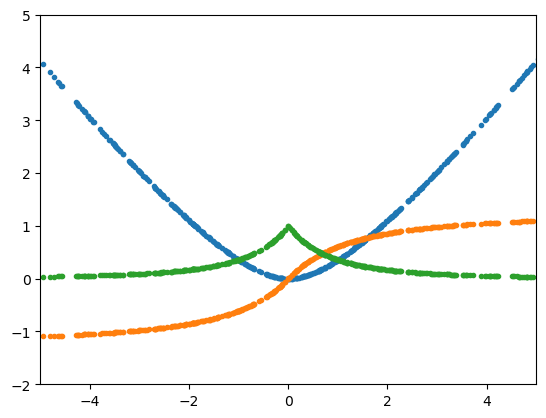

In [12]:
e = np.random.normal(size = 500, loc = 0, scale = 3)
rhos = zhang_rho(e)
psis = zhang_psi(e)
ws = zhang_w(e)
plt.plot(e, rhos, '.')
plt.plot(e, psis, '.')
plt.plot(e, ws, '.')
plt.xlim(-5, 5)
plt.ylim(-2,5)

## M-Estimador

La regresión con M-estimador es un método estadístico utilizado para realizar análisis de regresión en presencia de datos contaminados por errores atípicos o outliers. Este enfoque se diferencia de la regresión lineal tradicional al incorporar una función de influencia que ayuda a resistir la influencia excesiva de los puntos anormales en los datos.

Estos métodos están basados en estimadores de maxima verosimilitud.


In [13]:
def M_estimator(y,X, tol = 1e-15, iter_max = 10000, pr = False):
    corr_val = 1e-4
    alpha = 0.05
    
    beta_0 = OLS(y,X)
    e = (y - X.dot(beta_0.reshape(-1, 1)).reshape(1, -1)[0])
    sigma = MAD(e)
    e_s = e/sigma    
    wii = zhang_psi(e_s)/e_s
    
    outliers = robust_w(X, alpha)
    wii[outliers == 1] = corr_val 

    iter = 0

    while True:
        W = np.diag(wii)
        beta = np.linalg.inv(np.transpose(X).dot(W).dot(X)).dot(np.transpose(X).dot(W).dot(y))
        iter += 1

        if np.sqrt(sum((beta_0 - beta)**2)) < tol:
            #print("1")
            break
        if iter == iter_max:
            #print("2")
            break

        beta_0 = beta
        e = (y - X.dot(beta_0.reshape(-1, 1)).reshape(1, -1)[0])
        sigma = MAD(e)
        e_s = e/sigma
        wii = zhang_psi(e_s)/e_s
        wii[outliers == 1] = corr_val        
    if pr:
        print(f"numero de iteraciones: {iter}")
    return(beta)

### Prueba con datos genéricos

In [14]:
n = 100
x1 = np.random.normal(loc = 1, scale = 1, size = n)
x2 = np.random.normal(loc = 2, scale = 2, size = n)
x3 = np.random.normal(loc = 3, scale = 3, size = n)
e = np.random.normal(loc = 0, scale = np.sqrt(2), size = n)

beta0 = 1.20
beta1 = 9.76
beta2 = 6.89
beta3 = 3.53

y = beta0 + beta1*x1 + beta2*x2 + beta3*x3 + e

X = np.column_stack([np.ones(n),x1, x2, x3])
betas = M_estimator(y, X, pr=True)

print(betas)

numero de iteraciones: 10000
[1.6180222  9.58345469 6.88605387 3.48433359]


### Prueba con datos contaminados

In [15]:
Xc = cont(x1, x2, x3, e, n, 0.09)
betasc = M_estimator(y, Xc, pr = True)
print(betasc)

numero de iteraciones: 10000
[1.70425393 9.70552334 6.79536492 3.42053688]


## a) Prueba del algoritmo

In [17]:
# ns = [10, 50, 100]    # Prueba corta
# N = 10     # Prueba corta
ns = [100, 500, 1000]
N = 10000
betas = [beta0, beta1, beta2, beta3]
MSE = []
MAE = []
AIC = []
BIC = []
for n in ns:
    mse = 0
    mae = 0
    aic = 0
    bic = 0
    for i in range(N):
        x1 = np.random.normal(loc = 1, scale = 1, size = n)
        x2 = np.random.normal(loc = 2, scale = 2, size = n)
        x3 = np.random.normal(loc = 3, scale = 3, size = n)
        e = np.random.normal(loc = 0, scale = np.sqrt(2), size = n)
        y = beta0 + beta1*x1 + beta2*x2 + beta3*x3

        Xc = cont(x1, x2, x3, e, n, 0.09)
        betasc = M_estimator(y, Xc, tol = 1e-5, iter_max = 1000, pr = False)
        #print(betasc)
        y_est = betasc[0] + betasc[1]*x1 + betasc[2]*x2 + betasc[3]*x3
        error = y - y_est
        
        mse +=  sum(error ** 2)/n
        mae += sum(abs(error))/n
        
        rss = sum(error ** 2)
        k = 4
        aic += n * np.log(rss/n) + 2 * k
        bic += n * np.log(rss/n) + k * np.log(n)  
        
        if i % 2000 == 0:
            print(f"n = {n}, iter = {i}")              
    mse = mse/N
    mae = mae/N
    aic = aic/N
    bic = bic/N
    
    MSE.append(mse)
    MAE.append(mae)
    AIC.append(aic)
    BIC.append(bic)
    print(f"El algoritmo se ejecutó para n = {n}")

n = 100, iter = 0
n = 100, iter = 2000
n = 100, iter = 4000
n = 100, iter = 6000
n = 100, iter = 8000
El algoritmo se ejecutó para n = 100
n = 500, iter = 0
n = 500, iter = 2000
n = 500, iter = 4000
n = 500, iter = 6000
n = 500, iter = 8000
El algoritmo se ejecutó para n = 500
n = 1000, iter = 0
n = 1000, iter = 2000
n = 1000, iter = 4000
n = 1000, iter = 6000
n = 1000, iter = 8000
El algoritmo se ejecutó para n = 1000


### Resultados de MSE y MAE
Para n = 100, n = 500 y n = 1000

In [18]:
print(f"los valores de MSE son: {MSE}")
print(f"los valores de MAE son: {MAE}")
print(f"los valores de AIC son: {AIC}")
print(f"los valores de BIC son: {BIC}")

los valores de MSE son: [0.04062659130415004, 0.03670127505299317, 0.03625523669249671]
los valores de MAE son: [0.15797146030761022, 0.1524734668888388, 0.1517605895748961]
los valores de AIC son: [-317.55419413012976, -1647.5183153496155, -3312.1982364691103]
los valores de BIC son: [-307.1335133861755, -1630.659882955918, -3292.567215353182]


Vemos que, en promedio, a mayor tamaño de muestra, menor son los errores; es decir, más hacertada es la estimación.

# b) Implementación en datos "Abalone"

Luego del análisis de correlación de los datos, se eligen las características más relevantes.

In [19]:
n = y_abalone.shape[0]

X_abal = np.column_stack([np.ones(n), abalone_x1, abalone_x2, abalone_x3])
y_abal = y_abalone.values.ravel() # Para que tenga la forma adecuada

betas = M_estimator(y_abal, X_abal, 1e-15, 1000)     # Prueba corta
betas

array([ 5.19408009, 27.47268981, 17.25552389, -5.10309541])

## Remuestreo para hacer intervalos de confianza al 95%

In [20]:
#Remuestreo de bootstrap para el cálculo de los intervalos de confianza al 95%

def bootstrap(y, X, B = 1000):
    n = y.shape[0]
    betas = np.zeros((B, X.shape[1]))
    for i in range(B):
        indices = np.random.choice(range(n), size = n, replace = True)
        y_boot = y[indices]
        X_boot = X[indices]
        betas[i] = M_estimator(y_boot, X_boot, 1e-8, 300)
    return betas

betas_boot = bootstrap(y_abal, X_abal, 1000)
betas_boot

# Cálculo de los intervalos de confianza al 95%


array([[ 5.8340628 , 27.325815  ,  9.22387732, -4.54219161],
       [ 4.81304288, 27.49565234, 21.8255555 , -5.4797517 ],
       [ 5.1626828 , 26.80231755, 18.18107758, -5.03823271],
       ...,
       [ 5.18299837, 25.84343949, 17.7681599 , -4.70592943],
       [ 5.81602763, 26.92888912,  9.78239086, -4.40205611],
       [ 3.9478396 , 27.22102065, 33.27545147, -6.18361151]])

(array([ 1.,  0.,  0.,  3.,  2., 13.,  9., 22., 21., 24., 38., 37., 57.,
        65., 64., 77., 69., 70., 80., 71., 63., 62., 41., 36., 29., 17.,
        16.,  6.,  3.,  4.]),
 array([21.08667148, 21.44431409, 21.80195671, 22.15959932, 22.51724194,
        22.87488455, 23.23252717, 23.59016979, 23.9478124 , 24.30545502,
        24.66309763, 25.02074025, 25.37838286, 25.73602548, 26.09366809,
        26.45131071, 26.80895333, 27.16659594, 27.52423856, 27.88188117,
        28.23952379, 28.5971664 , 28.95480902, 29.31245163, 29.67009425,
        30.02773687, 30.38537948, 30.7430221 , 31.10066471, 31.45830733,
        31.81594994]),
 <BarContainer object of 30 artists>)

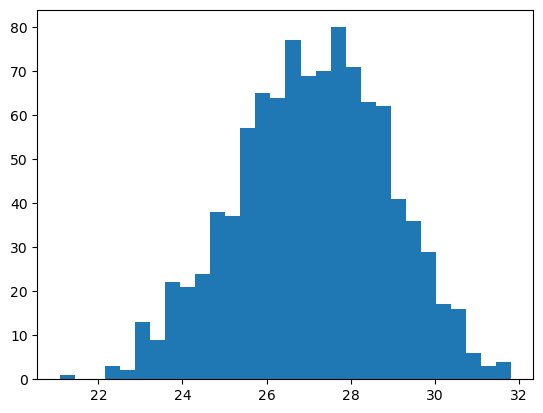

In [28]:
#Graficar beta_0

plt.hist(betas_boot[:,1], bins = 30)

In [23]:
#Calcular intervalo de confianza para beta_0

ci_95 = []

for i in range(0, 4):
    ci_low = np.percentile(betas_boot[:,i], 2.75)
    ci_upper = np.percentile(betas_boot[:,i], 97.5)

    ci_95.append([ci_low, ci_upper])

print(ci_95)

[[3.7192530267944415, 5.923043381740277], [23.599919089321045, 30.512829890204777], [8.120446958975622, 36.10977350501416], [-6.139730347307036, -4.348641827134282]]


In [24]:
print(f"El intervalo de confianza para beta_0 es: {ci_95[0]}")
print(f"El intervalo de confianza para beta_1 es: {ci_95[1]}")
print(f"El intervalo de confianza para beta_2 es: {ci_95[2]}")
print(f"El intervalo de confianza para beta_3 es: {ci_95[3]}")

El intervalo de confianza para beta_0 es: [3.7192530267944415, 5.923043381740277]
El intervalo de confianza para beta_1 es: [23.599919089321045, 30.512829890204777]
El intervalo de confianza para beta_2 es: [8.120446958975622, 36.10977350501416]
El intervalo de confianza para beta_3 es: [-6.139730347307036, -4.348641827134282]


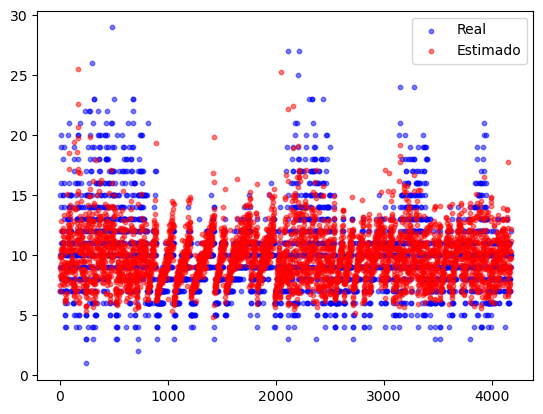

In [42]:
#Graficar la edad vs la funcion con los betas estimados

y_est = betas[0] + betas[1]*abalone_x1 + betas[2]*abalone_x2 + betas[3]*abalone_x3
x = np.arange(0, len(y_abal))

plt.scatter(x, y_abal, label = "Real", alpha = 0.5, color = "blue", s = 10)
plt.scatter(x, y_est, label = "Estimado", alpha = 0.5, color = "red", s = 10)
plt.legend()
plt.show()

In [58]:
betas

array([ 5.19408009, 27.47268981, 17.25552389, -5.10309541])

In [57]:
pd.DataFrame([y_est, y_abal], index = ["Estimado", "Real"]).T

,Estimado,Real
0,8.331267,15.0
1,7.519418,7.0
2,9.838045,9.0
3,8.976090,10.0
4,7.039385,7.0
...,...,...
4172,10.355496,11.0
4173,9.750621,10.0
4174,11.191811,9.0
4175,10.328987,10.0


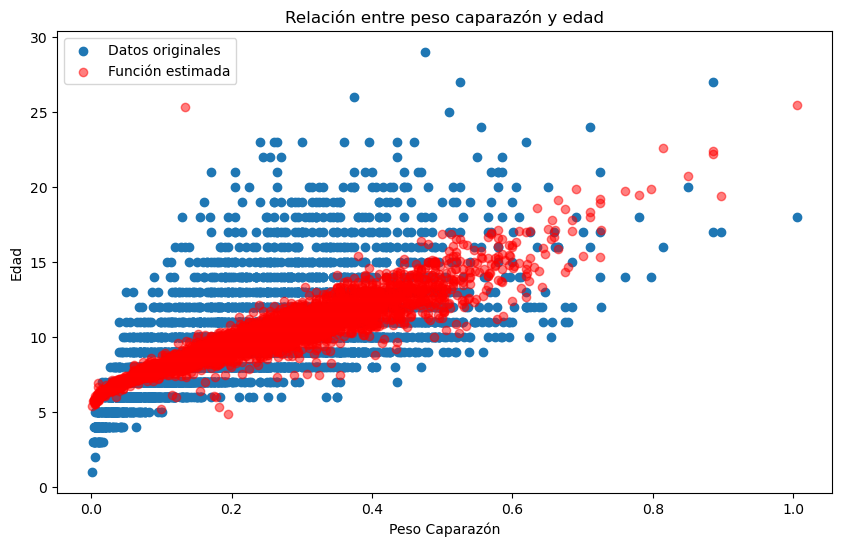

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(abalone_x1, y_abal, label='Datos originales')
plt.scatter(abalone_x1, y_est, color='red', label='Función estimada', alpha=0.5)
plt.xlabel('Peso Caparazón')
plt.ylabel('Edad')
plt.title('Relación entre peso caparazón y edad')
plt.legend()
plt.show()


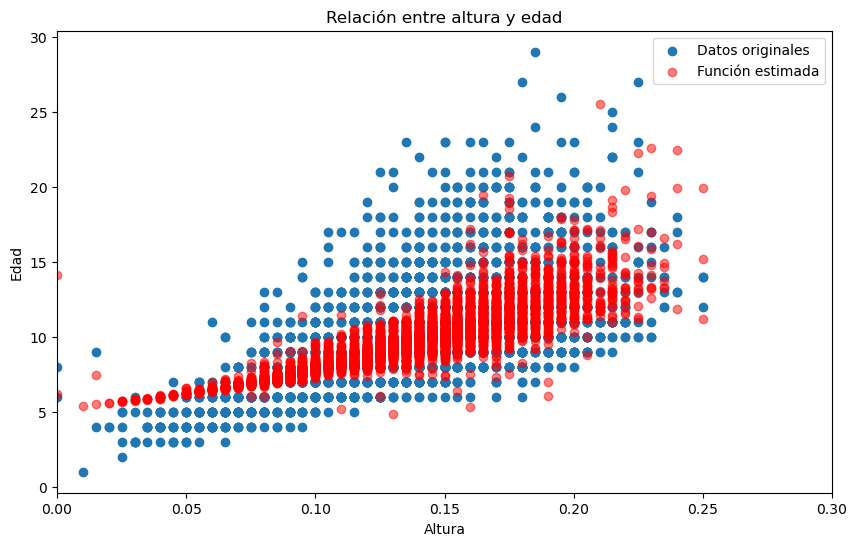

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(abalone_x2, y_abal, label='Datos originales')
plt.scatter(abalone_x2, y_est, color='red', label='Función estimada', alpha=0.5)
plt.xlabel('Altura')
plt.ylabel('Edad')
plt.xlim(0, 0.3)
plt.title('Relación entre altura y edad')
plt.legend()
plt.show()


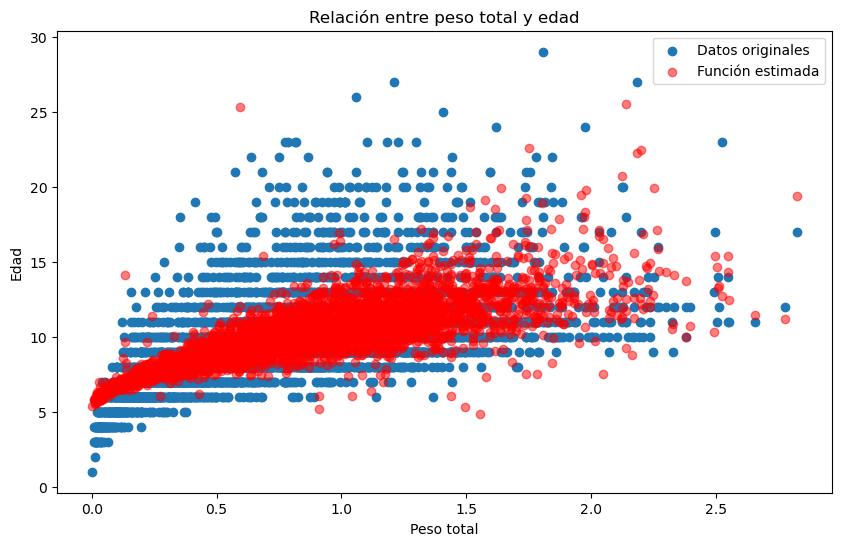

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(abalone_x3, y_abal, label='Datos originales')
plt.scatter(abalone_x3, y_est, color='red', label='Función estimada', alpha=0.5)
plt.xlabel('Peso total')
plt.ylabel('Edad')
plt.title('Relación entre peso total y edad')
plt.legend()
plt.show()
